# Image classifier using MobileNetV2

### 1. Imports - All necessary libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

### 2. Data loading - Basic setup working

In [2]:
dataset_path = 'Animals'
print("Dataset directory contents:")
print(os.listdir(dataset_path))

# Check class distribution
print("\nClass Distribution:")
total_images = 0
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        print(f"{class_name}: {num_images} images")
        total_images += num_images

print(f"\nTotal classes: {len(os.listdir(dataset_path))}")
print(f"Total images: {total_images}")

Dataset directory contents:
['cats', 'dogs', 'snakes']

Class Distribution:
cats: 1000 images
dogs: 1000 images
snakes: 1000 images

Total classes: 3
Total images: 3000


### 3. Data preprocessing - ImageDataGenerator with augmentation

In [3]:
img_height, img_width = 224, 224  # Standard for MobileNetV2
batch_size = 32

# Training data generator (with augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3,  # 70% train, 30% validation (we'll split validation further)
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Validation/Test data generator (no augmentation)
val_test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3
)

# Create generators
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

# Later we'll split this into validation and test
val_generator = val_test_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Number of classes: {train_generator.num_classes}")
print(f"Class indices: {train_generator.class_indices}")

Found 2100 images belonging to 3 classes.
Found 900 images belonging to 3 classes.
Training samples: 2100
Validation samples: 900
Number of classes: 3
Class indices: {'cats': 0, 'dogs': 1, 'snakes': 2}


### 4: DATA VISUALIZATION

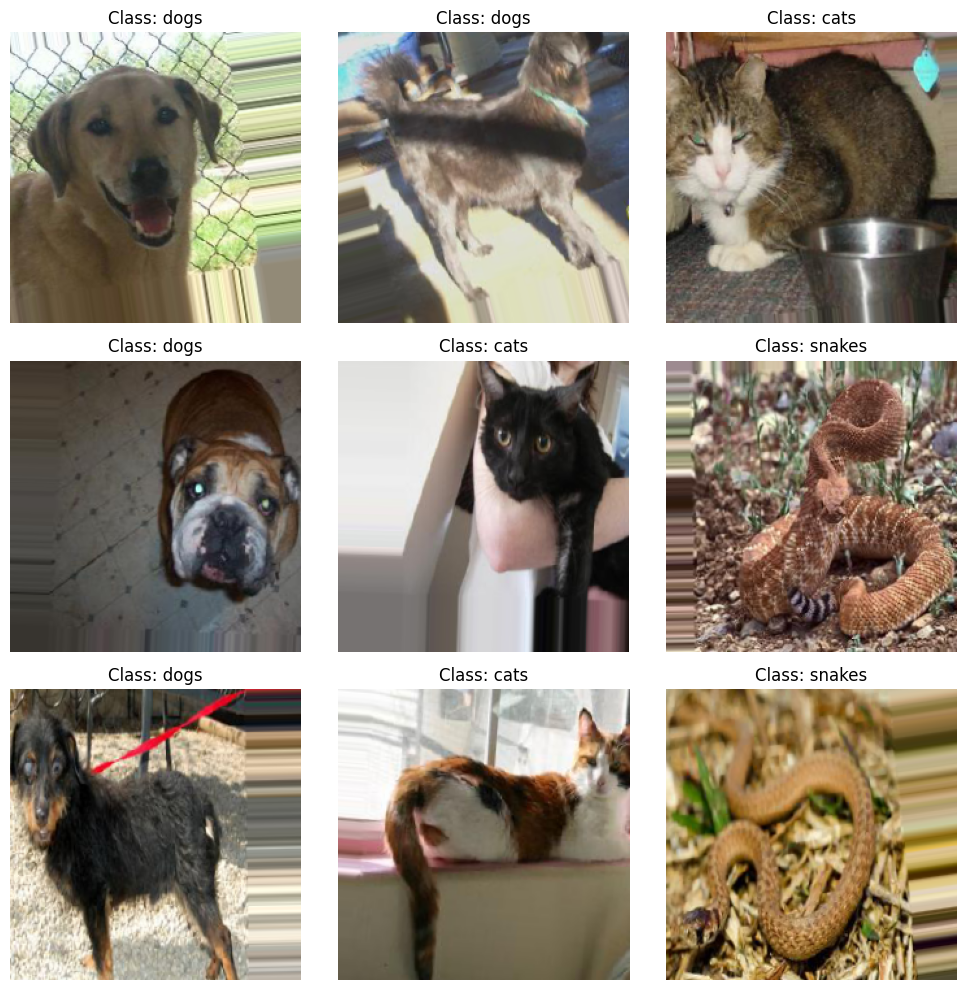

Image batch shape: (32, 224, 224, 3)
Labels batch shape: (32, 3)
Class indices mapping: {'cats': 0, 'dogs': 1, 'snakes': 2}
Number of classes: 3


In [4]:
# Get a batch of images and labels
images, labels = next(train_generator)

# Create reverse mapping from indices to class names
class_names = {v: k for k, v in train_generator.class_indices.items()}

# Show first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    
    # Get the actual class name for this image
    predicted_class_index = np.argmax(labels[i])
    class_name = class_names[predicted_class_index]
    
    plt.title(f"Class: {class_name}")
    plt.axis("off")
plt.tight_layout()
plt.show()

# Print some useful info
print(f"Image batch shape: {images.shape}")
print(f"Labels batch shape: {labels.shape}")
print(f"Class indices mapping: {train_generator.class_indices}")
print(f"Number of classes: {len(train_generator.class_indices)}")

### 5. Model creation - MobileNetV2 with frozen layers

In [5]:
# Load MobileNetV2 without the top layer (no classifier), with ImageNet weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers so they are not trained initially
base_model.trainable = False

print(f"Base model has {len(base_model.layers)} layers")
print(f"Base model trainable parameters: {base_model.count_params()}")

# Add custom classification layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)           # Flatten feature maps to vector
x = Dense(128, activation='relu')(x)      # Feature extraction layer
x = Dropout(0.5)(x)                       # Reduce overfitting
predictions = Dense(3, activation='softmax')(x)  # 3 classes: dogs, cats, snakes

# Define the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with Adam optimizer and categorical crossentropy loss
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Show model summary and trainable parameters
print("\n" + "="*50)
print("MODEL SUMMARY")
print("="*50)
model.summary()

print(f"\nTotal parameters: {model.count_params():,}")
print(f"Trainable parameters: {sum([np.prod(layer.get_weights()[0].shape) + np.prod(layer.get_weights()[1].shape) if layer.get_weights() else 0 for layer in model.layers if layer.trainable]):,}")

Base model has 154 layers
Base model trainable parameters: 2257984

MODEL SUMMARY


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


Total parameters: 2,422,339
Trainable parameters: 164,355


### 6. Training - With proper callbacks 

In [6]:

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)

print("Starting training...")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("Training completed!")

Starting training...
Training samples: 2100
Validation samples: 900


c:\Users\hrana\anaconda3\envs\ml_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 44s 601ms/step - accuracy: 0.5392 - loss: 1.0449 - val_accuracy: 0.9511 - val_loss: 0.2607 - learning_rate: 1.0000e-04
Epoch 2/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 38s 569ms/step - accuracy: 0.9116 - loss: 0.3118 - val_accuracy: 0.9678 - val_loss: 0.1344 - learning_rate: 1.0000e-04
Epoch 3/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 38s 570ms/step - accuracy: 0.9470 - loss: 0.1834 - val_accuracy: 0.9778 - val_loss: 0.0963 - learning_rate: 1.0000e-04
Epoch 4/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 44s 663ms/step - accuracy: 0.9561 - loss: 0.1401 - val_accuracy: 0.9811 - val_loss: 0.0832 - learning_rate: 1.0000e-04
Epoch 5/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 639ms/step - accuracy: 0.9546 - loss: 0.1288 - val_accuracy: 0.9722 - val_loss: 0.0943 - learning_rate: 1.0000e-04
Epoch 6/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 634ms/step - accuracy: 0.9572 - loss: 0.1094 - val_accuracy: 0.9756 - val_loss: 0.0804 - learning_rate: 1.0000e-04
Epoch 7/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 637ms/step - acc

In [7]:
# Create a separate test generator for final evaluation
# We'll manually split some validation data for testing
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,  # Important: don't shuffle test data
    seed=123  # Different seed to get different samples
)

# For a more proper split, we could manually organize our folders into:
# Animals/train/, Animals/val/, Animals/test/

Found 3000 images belonging to 3 classes.


### 7: TRAINING VISUALIZATION

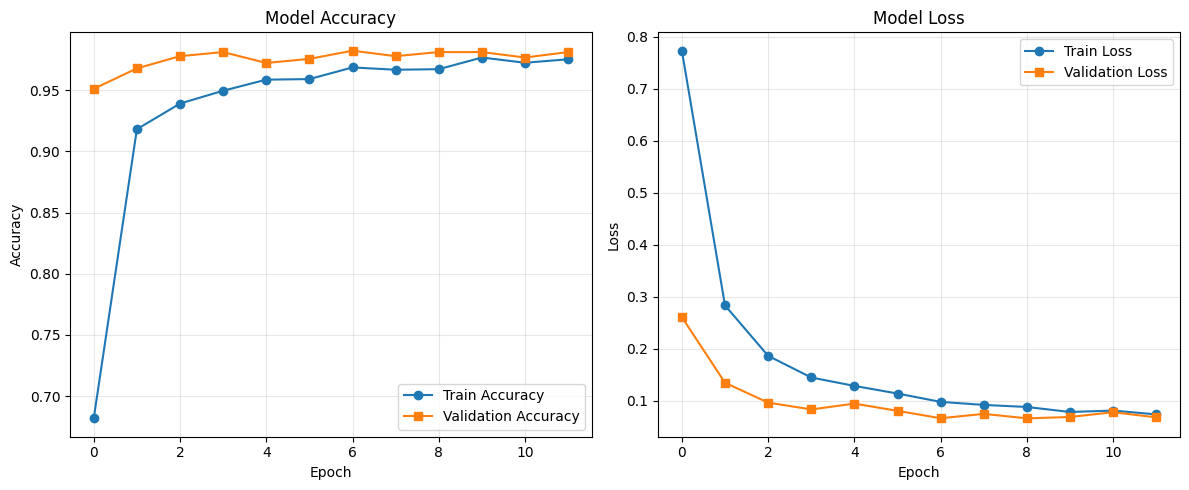

Training Summary:
Final train accuracy: 0.9752
Final validation accuracy: 0.9811
Final train loss: 0.0736
Final validation loss: 0.0679
Total epochs trained: 12

Good: No overfitting detected


In [8]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print some training statistics
print("Training Summary:")
print(f"Final train accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final train loss: {history.history['loss'][-1]:.4f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")
print(f"Total epochs trained: {len(history.history['accuracy'])}")

# Check for overfitting
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
if train_acc - val_acc > 0.1:
    print("\nWarning: Possible overfitting detected (train acc >> val acc)")
elif val_acc > train_acc:
    print("\nGood: No overfitting detected")
else:
    print("\nTraining looks healthy")

### 8: COMPREHENSIVE MODEL EVALUATION

MODEL EVALUATION RESULTS
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 280ms/step - accuracy: 0.9705 - loss: 0.0976

Validation Results:
Validation Loss: 0.0660
Validation Accuracy: 0.9811 (98.11%)

Generating predictions...
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 314ms/step


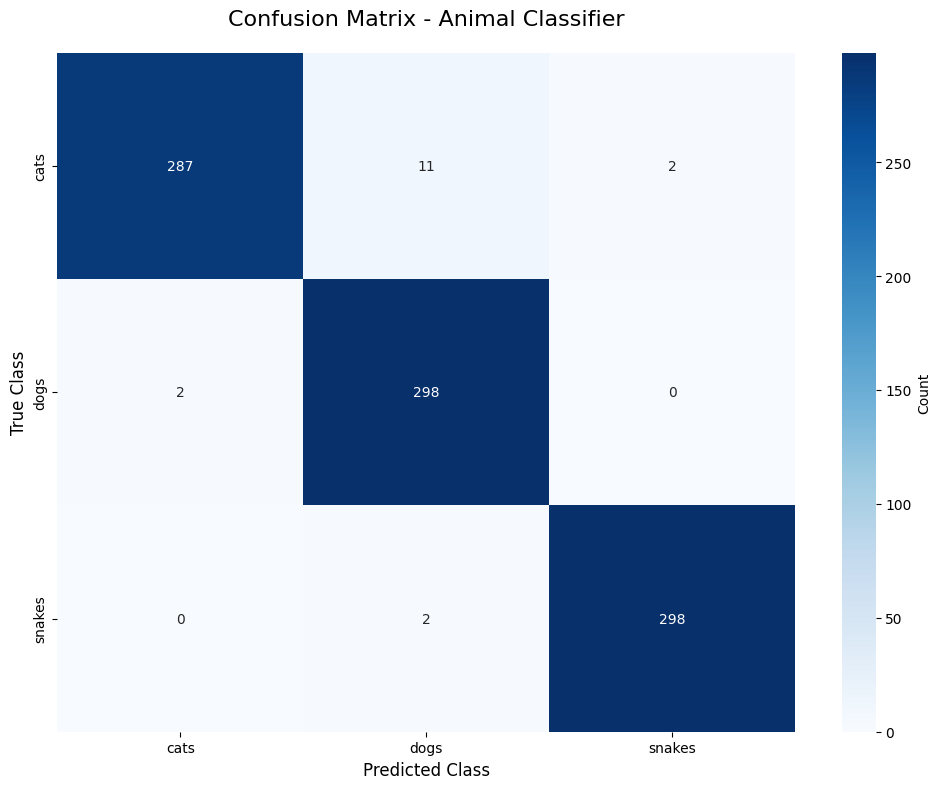


Per-Class Performance:
Cats: 0.9567 (95.67%)
Dogs: 0.9933 (99.33%)
Snakes: 0.9933 (99.33%)

Detailed Classification Report:
              precision    recall  f1-score   support

        cats     0.9931    0.9567    0.9745       300
        dogs     0.9582    0.9933    0.9755       300
      snakes     0.9933    0.9933    0.9933       300

    accuracy                         0.9811       900
   macro avg     0.9815    0.9811    0.9811       900
weighted avg     0.9815    0.9811    0.9811       900


Prediction Confidence Analysis:
Average confidence: 0.9762
Minimum confidence: 0.4375
Maximum confidence: 1.0000


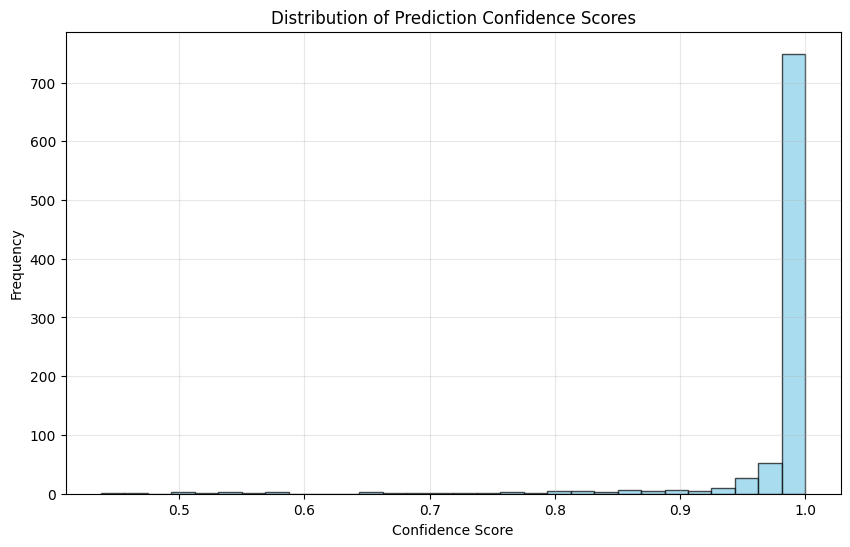


Sample Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


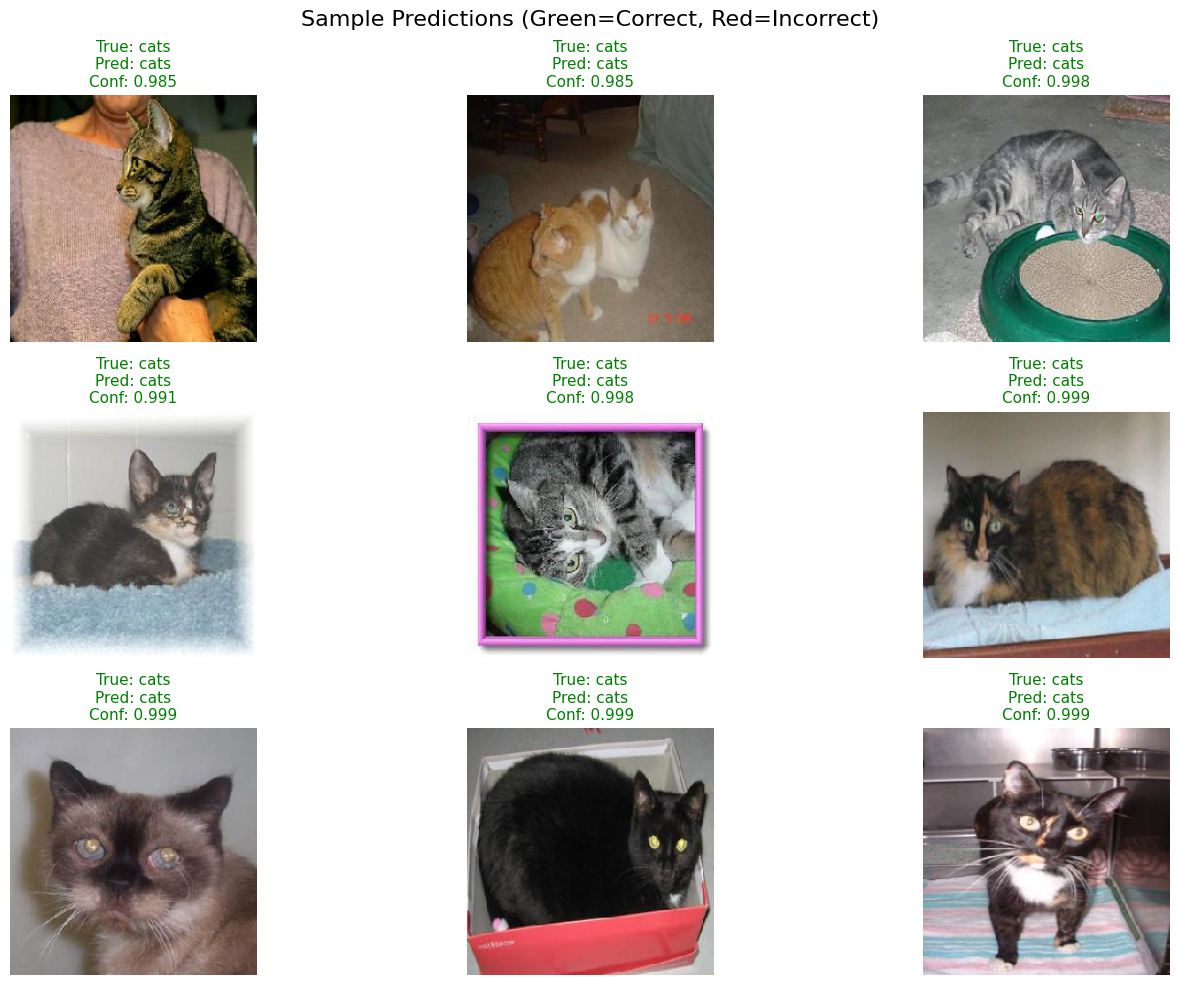


FINAL PERFORMANCE SUMMARY
Dataset: 900 images
Classes: 3 (cats, dogs, snakes)
Overall Accuracy: 0.9811 (98.11%)
Model Architecture: MobileNetV2 + Custom Head
Transfer Learning: (ImageNet pretrained)
Data Augmentation: 
Excellent performance!

Evaluation results saved to .npy files
Evaluation complete!


In [9]:
# 1. Basic Model Evaluation
print("="*50)
print("MODEL EVALUATION RESULTS")
print("="*50)

# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(val_generator, verbose=1)
print(f"\nValidation Results:")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")


# 2. CONFUSION MATRIX AND CLASSIFICATION REPORT

# Reset generator and get predictions
print("\nGenerating predictions...")
val_generator.reset()
predictions = model.predict(val_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = val_generator.classes
class_names = list(val_generator.class_indices.keys())

# Create and plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Animal Classifier', fontsize=16, pad=20)
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('True Class', fontsize=12)
plt.tight_layout()
plt.show()

# Calculate per-class accuracy
print("\nPer-Class Performance:")
for i, class_name in enumerate(class_names):
    class_accuracy = cm[i, i] / cm[i, :].sum()
    print(f"{class_name.capitalize()}: {class_accuracy:.4f} ({class_accuracy*100:.2f}%)")

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(true_classes, predicted_classes, 
                          target_names=class_names, digits=4))


# 3. PREDICTION CONFIDENCE ANALYSIS

print("\nPrediction Confidence Analysis:")
confidence_scores = np.max(predictions, axis=1)
print(f"Average confidence: {np.mean(confidence_scores):.4f}")
print(f"Minimum confidence: {np.min(confidence_scores):.4f}")
print(f"Maximum confidence: {np.max(confidence_scores):.4f}")

# Plot confidence distribution
plt.figure(figsize=(10, 6))
plt.hist(confidence_scores, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Prediction Confidence Scores')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()


# 4. SAMPLE PREDICTION VISUALIZATION

# Show some predictions with confidence scores
def show_predictions(generator, model, num_images=9):
    # Get a batch of images
    generator.reset()
    images, true_labels = next(generator)
    predictions = model.predict(images)
    
    # Create reverse mapping
    class_names = list(generator.class_indices.keys())
    
    plt.figure(figsize=(15, 10))
    for i in range(min(num_images, len(images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        # Get true and predicted classes
        true_class_idx = np.argmax(true_labels[i])
        pred_class_idx = np.argmax(predictions[i])
        confidence = np.max(predictions[i])
        
        true_class = class_names[true_class_idx]
        pred_class = class_names[pred_class_idx]
        
        # Color: green if correct, red if wrong
        color = 'green' if true_class_idx == pred_class_idx else 'red'
        
        plt.title(f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.3f}', 
                 color=color, fontsize=11)
        plt.axis('off')
    
    plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)', fontsize=16)
    plt.tight_layout()
    plt.show()

print("\nSample Predictions:")
show_predictions(val_generator, model, 9)


# 5. MODEL PERFORMANCE SUMMARY

print("\n" + "="*50)
print("FINAL PERFORMANCE SUMMARY")
print("="*50)

# Calculate overall metrics
total_samples = len(true_classes)
correct_predictions = np.sum(predicted_classes == true_classes)
overall_accuracy = correct_predictions / total_samples

print(f"Dataset: {total_samples} images")
print(f"Classes: {len(class_names)} ({', '.join(class_names)})")
print(f"Overall Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
print(f"Model Architecture: MobileNetV2 + Custom Head")
print(f"Transfer Learning: (ImageNet pretrained)")
print(f"Data Augmentation: ")

# Check if model is performing well
if overall_accuracy > 0.85:
    print("Excellent performance!")
elif overall_accuracy > 0.75:
    print("Good performance!")
elif overall_accuracy > 0.65:
    print("Moderate performance - consider more training/data")
else:
    print("Poor performance - needs improvement")

print("\n" + "="*50)


# 6. SAVE EVALUATION RESULTS

# Save predictions and results
np.save('predictions.npy', predictions)
np.save('true_classes.npy', true_classes)
np.save('predicted_classes.npy', predicted_classes)

print("Evaluation results saved to .npy files")
print("Evaluation complete!")

### 9. Model Saving

In [10]:
# Save the entire model to a file
model.save('animal_classifier_model.h5')
print("Model saved successfully as 'animal_classifier_model.h5'")

Model saved successfully as 'animal_classifier_model.h5'
